# 1 Instalação de pacotes

In [4]:
##pip install pyswarms ## Pacote PySwarm - otimização PSO (enxames)

# 2 Import Bibliotecas

In [5]:
## Swarm (Enxame)
import pyswarms as ps    ## Enxame
from pyswarms.utils.plotters import plot_cost_history ## Plot curva convergência enxame

## Data manipulation
import pandas as pd
import numpy as np

## Datasets
import openml  ## biblioteca para importar datasets

## Processamento
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score ## Métricas (função objetivo)
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

## Modelo SVC
from sklearn.svm import SVC

2024-04-29 00:15:44,881 - numexpr.utils - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-04-29 00:15:44,882 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2024-04-29 00:15:45,409 - openml.config - INFO - Error opening file C:\Users\pichau\.openml\config: not readable


# 3 Leitura dos dados

In [6]:
data = openml.datasets.get_dataset(58)

X, y, categorical_indicator, attribute_names = data.get_data(
    dataset_format = "array", target=data.default_target_attribute
)

X = pd.DataFrame(X, columns = attribute_names)
y = pd.Series(y)
X

C:\Users\pichau\AppData\Local\Temp\ipykernel_8236\758860786.py:1: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  data = openml.datasets.get_dataset(58)
C:\Users\pichau\AppData\Local\Temp\ipykernel_8236\758860786.py:3: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, categorical_indicator, attribute_names = data.get_data(
2024-04-29 00:15:46,335 - openml.datasets.dataset - INFO - pickle write vowel


,Train_or_Test,Speaker_Number,Sex,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9
0,1.0,0.0,1.0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814
1,1.0,0.0,1.0,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488
2,1.0,0.0,1.0,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049
3,1.0,0.0,1.0,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795
4,1.0,0.0,1.0,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396
...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0.0,14.0,0.0,-3.239,3.083,-1.427,-0.202,-0.282,1.421,0.576,0.068,-0.914,0.147
986,0.0,14.0,0.0,-3.753,3.605,-0.899,-0.747,-0.401,1.765,0.620,0.754,-0.835,-0.301
987,0.0,14.0,0.0,-3.980,2.459,0.068,0.023,0.237,1.029,-0.189,0.521,-0.773,-0.500
988,0.0,14.0,0.0,-4.264,2.925,0.065,0.794,0.323,0.515,-1.282,-0.140,-0.863,-0.390


In [7]:
y.value_counts()

8     90
2     90
1     90
0     90
5     90
6     90
3     90
9     90
4     90
10    90
7     90
Name: count, dtype: int64

In [8]:
num_columns = X.select_dtypes(include=['int32', 'int8', 'int64', 'float64', 'float32', 'float16']).columns
cat_columns = X.select_dtypes(exclude=['int32', 'int8', 'int64', 'float64', 'float32', 'float16', 'datetime64[ns]']).columns

In [9]:
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), ## Nem todo modelo consegue lidar com valores nulos, vamos automatizar o que fazer com os nulls (fill com mediana)
    ('scaler',StandardScaler())                    ## Nem todo modelo consegue lidar com a escala de todas as featues, vamos standardizá-las
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  ## Nem todo modelo consegue lidar com valores nulos, vamos automatizar o que fazer com os nulls (cat mais frequente)
    ('encoder', TargetEncoder())                           ## Para features categóricas vamos usar a informação conhecida do target para acelerar o aprendizado (tb transformando-os em numerico!)
])


preprocessor = ColumnTransformer([
    ('categorical', categorical_pipe, cat_columns),
    ('numeric', numeric_pipe, num_columns)
])

# 4 Splitting treino / test

- Como SVM é um algorítmo pesado computacionalmente vamos limitar os dados de treino para apenas 500 datapoints.

In [10]:
seed = 42 ## Reprodutibilidade do modelo

In [11]:
test_size = (len(X)-500)/len(X)
if test_size < 0:
    test_size= 0.3 ## Padrão 30% para o teste caso não haja 500 datapoints disponíveis para alocar nos dados de treino

test_size

0.494949494949495

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y, shuffle=True)

In [13]:
y_train.value_counts(), y_test.value_counts()

(0     46
 2     46
 9     46
 5     46
 10    46
 4     45
 8     45
 7     45
 3     45
 1     45
 6     45
 Name: count, dtype: int64,
 6     45
 8     45
 4     45
 1     45
 3     45
 7     45
 2     44
 0     44
 5     44
 10    44
 9     44
 Name: count, dtype: int64)

# 5 Setup PSO
- Vamos utilizar a inteligência de enxame (PSO) para encontrar os melhores hiperparâmetros num modelo SVM.
- Por questão de simplicidade e demonstração do PSO escolheremos apenas 2 hiperparâmetros a fim de visualizarmos o enxame num espaço 2D (R2).
- Escolhemos esse modelo, pois, os dois principais hiperparâmetros (C e gamma) são números contínuos (e não discretos), assim, conseguimos extrair o máximo potencial do PSO frente á outros métodos de tunning de hiperparâmetros discretos (como bayesiano - optuna ou por grid, por ex)

## 5.1 Espaço de hiperparâmetros:
- C: (0.01,100)
- gamma: (0.01,100)

In [14]:
## Especificando o espaço R2 varrido [C, gamma]
espaco = (np.array([0.01, 0.01]), np.array([100, 100]))
print(espaco)

(array([0.01, 0.01]), array([100, 100]))


## 5.2 Função Objetivo
Nossa função objetivo será a média da acurácia obtida em validação cruzada com 5 folds.


In [15]:
## Inicialização da variável para armazenar a posição das partículas
from collections import defaultdict 
results_dict = defaultdict(list)
results_dict

defaultdict(list, {})

In [16]:
## Função objetivo (fitness):
# customized fitness_function 
def fitness_function(posicoes, X_train, y_train, results_dict, seed):

  ## posicoes = array com todos [C,gamma] da partícula
  ## X_train = dados de treino
  ## y_train = rótulo dos dados de treino
  ## resultados = variável criada anteriormente para armazenar as posições de todas as particulas e as suas movimentações em cada iteraçao
  ## seed = variável para reprodutibilidade do experimento

  #print(candidates)
  acc_scores = []
  for pos in posicoes:
   
    #print(pos)
    C = pos[0]
    gamma = pos[1]

    model = SVC(random_state=seed)
    model.set_params(**{'C': C, 'gamma': gamma})
 
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    scores = cross_val_score(pipe, X=X_train, y = y_train, cv=5)
    accuracy = scores.mean()
    acc_scores.append(accuracy)
    
    # saving results    
    results_dict['seed'].append(seed)
    results_dict['C'].append(C)
    results_dict['gamma'].append(gamma)
    results_dict['accuracy'].append(accuracy)

  
  ## Como por padrão a biblioteca pyswarms retorna um min() como função objetivo, vamos usar de return da função fitness a acurácia * (-1) para encontrar o mínimo
  return_accuracy_scores = -np.array(acc_scores)

  return return_accuracy_scores

## 5.3 Posicao e vetor de velocidade

### Função posição das partículas
A posição nada mais é que o conjunto de hiperparâmetros [C, gamma]

A função da posição de cada particula é representada por:  
xi(t+1)=xi(t)+vi(t+1)


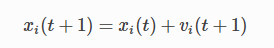

In [45]:
from IPython import display
display.Image("./images/eq_posicao.png")

### Função velocidade das partículas
Onde a velocidade é:  
vij(t+1)= w∗vij(t)  +  c1r1j(t)[yij(t)−xij(t)]  +  c2r2j(t)[y^j(t)−xij(t)]


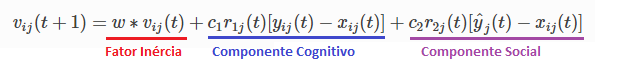

In [46]:
from IPython import display
display.Image("./images/eq_velocidade.png")


### Parâmetros da velocidade das partículas
w:  parâmetro que define o grau de inércia da partícula sobre o deslocamento da partícula. (Inércia)  
c1: parâmetro que define o quanto seu próprio histórico de explorar o espaço na busca pela melhor posição influencia no seu próprio deslocamento.  (Componente cognitivo)  
c2: parâmetro que define o quanto a melhor posição do enxame como um todo influência no seu próprio deslocamento.  (Componente social)  

r1 e r2: geradas aleatoriamente a cada iteração para permitir que o enxame explore mais o espaço e evitar que fique estacionado em algum mínimo local.

In [49]:
## Inicialização das variáveis de inércia, componente cognitivo e componente social
vars_velocidade = {'w':0.7, 'c1': 0.4, 'c2': 0.4}

## 5.4 Tamanho do enxame (particulas) e simulações

In [51]:
# Qtd de partículas do enxame e numero de iterações (movimentos)
n_particles = 15 ## 15 particulas se movimentando
iters       = 80 ## 80 movimentos de cada partícula

## 5.5 Instanciando e simulando o enxame - PSO

In [52]:
## Instanciando o PSO
optimizer = ps.single.GlobalBestPSO(
     n_particles = n_particles, 
     dimensions  = 2,                  #  dimensoes do problema (2 = dois hiperparâmetros, espaço R2)
     bounds      = espaco,
     options     = vars_velocidade
)

In [53]:
# Running PSO
stats = optimizer.optimize(
    fitness_function,             # funcao objetivo
    iters = iters,                # iterações
    X_train = X_train,            # dados treino
    y_train = y_train,            # rótulos treino
    results_dict = results_dict,    # variável para salvar posição de todas as partículas em cada iteração
    seed = seed                   # seed reprodutibilidade do experimento
)                  


2024-04-28 22:03:24,204 - pyswarms.single.global_best - INFO - Optimize for 80 iters with {'w': 0.7, 'c1': 0.4, 'c2': 0.4}
pyswarms.single.global_best: 100%|██████████|80/80, best_cost=-.94 
2024-04-28 22:06:11,717 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9399999999999998, best pos: [66.29899146  0.07833738]


# 6 Avaliação dos resultados

## 6.1 Melhor acurácia e hiperparâmetros

In [54]:
## Melhor acurácia obtida
best_accuracy = -1 * stats[0]
best_accuracy

0.9399999999999998

In [55]:
## Melhor hiperparâmetro onde ocorreu a melhor acurácia (posição da melhor particula).
melhor_posicao = stats[1]
melhor_posicao

array([66.29899146,  0.07833738])

In [56]:
melhor_C = melhor_posicao[0]
melhor_gamma = melhor_posicao[1]
print(f"Melhor conjunto de hiperparâmetros C = {melhor_C} e gamma = {melhor_gamma}")

Melhor conjunto de hiperparâmetros C = 66.29899146164749 e gamma = 0.07833737695756327


## 6.2 Acuracia vs Iterações

<Axes: title={'center': 'Cost History'}, xlabel='Iterations', ylabel='Cost'>

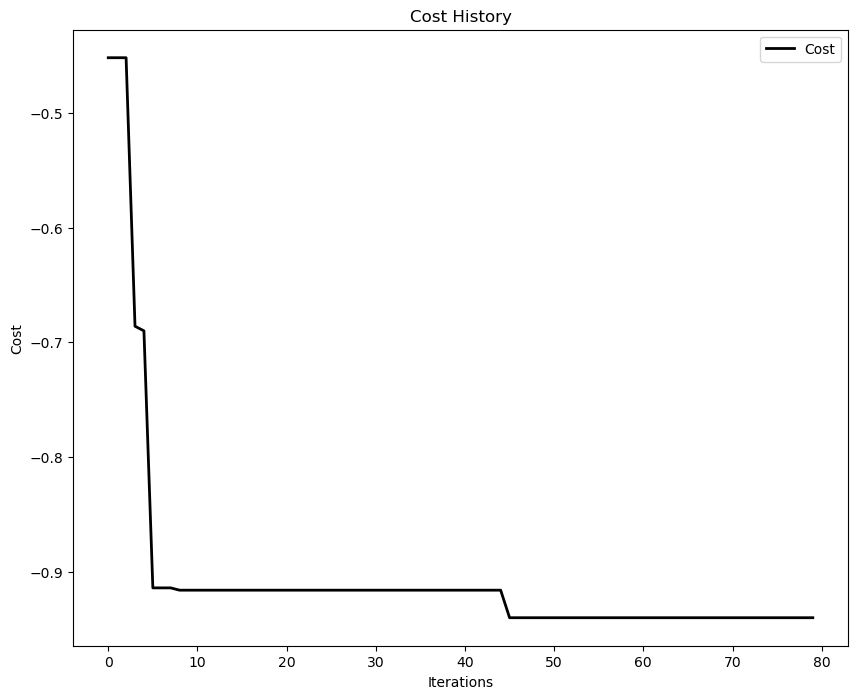

In [57]:
plot_cost_history(optimizer.cost_history)

- Já observamos uma acurácia acima de 90% entre a 5 e 10ª iteração! - Após essa iteração o enxame continua explorando o espaço e encontra a melhor acurácia de 94% entre a 40ª e 50ª iteração
-  Após essas iterações o exame continua explorando o espaço e nenhum conjunto de hiperparâmetro que apresente acurácia maior é encontrado.

# 6.3 Posição particulas em cada iteração

In [58]:
## Recuperando posicoes
df_posicoes = pd.DataFrame(results_dict)

## Identificando as partículas
df_posicoes = df_posicoes.reset_index(names = 'particle')
df_posicoes['particle'] = df_posicoes['particle'].apply(lambda x: x % (n_particles))
df_posicoes['particle'] = df_posicoes['particle'] + 1
df_posicoes

## Identificando as iteracoes
df_posicoes = df_posicoes.reset_index(names = 'iteracao')
df_posicoes['iteracao'] = df_posicoes['iteracao'] + 1
df_posicoes['iteracao'] = df_posicoes['iteracao'].apply(lambda x: np.ceil(x/n_particles))
df_posicoes

,iteracao,particle,seed,C,gamma,accuracy
0,1.0,1,42,50.639742,83.973256,0.142
1,1.0,2,42,64.296279,9.195414,0.452
2,1.0,3,42,37.816269,49.652642,0.166
3,1.0,4,42,54.965895,39.350693,0.192
4,1.0,5,42,24.605645,97.893175,0.134
...,...,...,...,...,...,...
1195,80.0,11,42,66.300164,65.418050,0.144
1196,80.0,12,42,67.927534,80.264678,0.142
1197,80.0,13,42,66.013739,78.251003,0.142
1198,80.0,14,42,66.412284,77.580351,0.144


In [59]:
df_posicoes[df_posicoes['accuracy']==best_accuracy]

,iteracao,particle,seed,C,gamma,accuracy
685,46.0,11,42,66.298991,0.078337,0.94


In [81]:
df_posicoes.sort_values(by = 'accuracy', ascending=False)

,iteracao,particle,seed,C,gamma,accuracy
685,46.0,11,42,66.298991,0.078337,0.940
702,47.0,13,42,65.492584,0.189418,0.922
928,62.0,14,42,66.676431,0.243220,0.920
121,9.0,2,42,69.006671,0.394943,0.916
883,59.0,14,42,67.132958,0.337821,0.916
...,...,...,...,...,...,...
60,5.0,1,42,58.092077,99.749809,0.132
824,55.0,15,42,64.286478,99.561447,0.132
445,30.0,11,42,68.211562,99.646199,0.132
216,15.0,7,42,68.362142,99.747660,0.132


- A melhor acurácia observada foi obtida pela partícula 11 na sua 46ª iteração
- Ja na 9ª iteração o algorítmo foi capaz de encontrar hiperparametros com 91.6% de acurácia!

In [65]:
df_pos_inicial = df_posicoes[df_posicoes['iteracao']==1]
df_pos_final = df_posicoes[df_posicoes['iteracao']==46] ## Após a 46º iteração o enxame continua explorando o espaço mas essa é a iteração que retornou o melhor resultado individual de uma particula

In [66]:
df_pos_inicial

,iteracao,particle,seed,C,gamma,accuracy
0,1.0,1,42,50.639742,83.973256,0.142
1,1.0,2,42,64.296279,9.195414,0.452
2,1.0,3,42,37.816269,49.652642,0.166
3,1.0,4,42,54.965895,39.350693,0.192
4,1.0,5,42,24.605645,97.893175,0.134
5,1.0,6,42,45.913118,49.094973,0.168
6,1.0,7,42,24.177448,52.251048,0.162
7,1.0,8,42,85.153231,91.851059,0.140
8,1.0,9,42,3.079564,81.403492,0.142
9,1.0,10,42,32.608643,79.111911,0.142


In [67]:
df_pos_final

,iteracao,particle,seed,C,gamma,accuracy
675,46.0,1,42,68.193301,65.137292,0.144
676,46.0,2,42,68.996180,98.608110,0.134
677,46.0,3,42,68.118148,94.361710,0.138
678,46.0,4,42,68.805383,78.048550,0.142
679,46.0,5,42,68.380406,49.148886,0.168
680,46.0,6,42,68.865052,63.705694,0.144
681,46.0,7,42,69.113024,69.389037,0.144
682,46.0,8,42,64.714206,57.835661,0.154
683,46.0,9,42,64.546606,72.793911,0.144
684,46.0,10,42,68.844119,92.301117,0.140


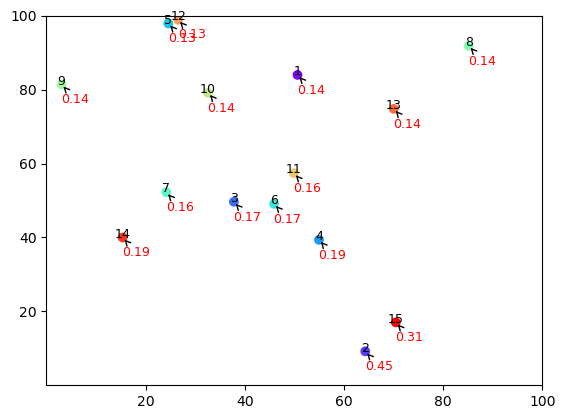

In [68]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Define o número de pontos
num_pontos = n_particles

# Cria as posições iniciais e finais para os pontos
x_inicial = df_pos_inicial['C'].values
y_inicial = df_pos_inicial['gamma'].values

x_final = df_pos_final['C'].values
y_final = df_pos_final['gamma'].values

# Define cores para cada ponto
colors = plt.cm.rainbow(np.linspace(0, 1, num_pontos))

# Gera valores aleatórios para as flechas
flechas_iniciais = df_pos_inicial.accuracy.values
flechas_finais = df_pos_final.accuracy.values

# Cria a figura e o eixo
fig, ax = plt.subplots()

# Define os limites do gráfico para garantir que todos os pontos sejam visíveis
ax.set_xlim(0.01, 100)
ax.set_ylim(0.01, 100)

# Cria o scatter plot para a animação
scatter = ax.scatter(x_inicial, y_inicial, c=colors)

# Rótulos para cada ponto
labels = [ax.text(x, y, str(i + 1), fontsize=9, ha='center') for i, (x, y) in enumerate(zip(x_inicial, y_inicial))]

# Adiciona flechas para os pontos iniciais
flechas_iniciais_annot = [
    ax.annotate(
        f"{flechas_iniciais[i]:.2f}",
        xy=(x_inicial[i], y_inicial[i]),
        xytext=(x_inicial[i] - 0.1, y_inicial[i] - 5),  # Aproximação do texto para encurtar a flecha
        textcoords="data",
        arrowprops=dict(arrowstyle="->", color="black"),
        fontsize=9,
        color="red",
    )
    for i in range(num_pontos)
]

# Número de quadros para a animação
num_frames = 100

# Função para atualizar a posição dos pontos e das anotações em cada quadro
def update(frame):
    # Interpolação linear entre posições iniciais e finais
    x_interpolated = x_inicial + frame * (x_final - x_inicial) / num_frames
    y_interpolated = y_inicial + frame * (y_final - y_inicial) / num_frames
    
    scatter.set_offsets(np.column_stack((x_interpolated, y_interpolated)))
    
    # Atualiza a posição dos rótulos
    for label, x, y in zip(labels, x_interpolated, y_interpolated):
        label.set_position((x, y))
    
    # Controla as flechas para mostrar apenas no início e no final
    if frame == 0:
        for flecha in flechas_iniciais_annot:
            flecha.set_visible(True)
    elif frame == num_frames - 1:

        # No final, atualiza as flechas com valores de acuracia
        flechas_finais_annot = [
            ax.annotate(
                f"{flechas_finais[i]:.2f}",
                xy=(x_interpolated[i], y_interpolated[i]),
                xytext=(x_interpolated[i] - 0.1, y_interpolated[i] - 5),  # Menos cumprido
                textcoords="data",
                arrowprops=dict(arrowstyle="->", color="black"),
                fontsize=9,
                color="red",
            )
            for i in range(num_pontos)
        ]
        return scatter, *labels, *flechas_finais_annot
    else:

        # No meio da animação, tornamos as flechas invisíveis
        for flecha in flechas_iniciais_annot:
            flecha.set_visible(False)
    
    return scatter, *labels

# Cria a animação
anim = animation.FuncAnimation(
    fig, update, frames=num_frames, blit=True, interval=50, repeat=False
)

# Exibe a animação
plt.show()

In [69]:
## anim.save("./images/animação.gif", writer="imagemagick")

# 7 Acurácia no espaço vetorial - FORÇA BRUTA!
- Vamos mapear os resultados da acuracia por meio da força bruta e comparar a convergência da otimização por enxame de particulas nesse espaço.  
- C em [0.01,100]  
- gamma em [0.01,100]  

In [70]:
espaco_C = np.arange(0.01, 100, 1, dtype=float)
espaco_gamma = np.arange(0.01, 100, 1, dtype=float)

## Adicionando o melhor ponto encontrado pelo PSO
espaco_C = np.append(espaco_C, melhor_C, axis=None)
espaco_C = np.sort(espaco_C, axis=-1, kind=None, order=None)

espaco_gamma = np.append(espaco_gamma, melhor_gamma, axis=None)
espaco_gamma = np.sort(espaco_gamma, axis=-1, kind=None, order=None)

In [71]:
seed = 42
df_acuracia_espaco = pd.DataFrame()

num_it = 1
total_iteracoes = len(espaco_C) * len(espaco_gamma)

for C in espaco_C:
    for gamma in espaco_gamma:
    

        model = SVC(random_state=seed)
        model.set_params(**{'C': C, 'gamma': gamma})

        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        scores = cross_val_score(pipe, X=X_train, y = y_train, cv=5)
        accuracy = scores.mean()
        
        ## Armazenando dados do espaço percorrido
        df_iteradao = pd.DataFrame(np.array([[C,gamma,accuracy]]), columns = ['C','gamma','accuracy'])
        df_acuracia_espaco = pd.concat([df_acuracia_espaco, df_iteradao])

        
        ##report status:
        num_it = num_it + 1
        if num_it%100==0:
            print(f'iteracao {num_it} finalizada - {round(100*num_it/total_iteracoes,2)}%')


iteracao 100 finalizada - 0.98%
iteracao 200 finalizada - 1.96%
iteracao 300 finalizada - 2.94%
iteracao 400 finalizada - 3.92%
iteracao 500 finalizada - 4.9%
iteracao 600 finalizada - 5.88%
iteracao 700 finalizada - 6.86%
iteracao 800 finalizada - 7.84%
iteracao 900 finalizada - 8.82%
iteracao 1000 finalizada - 9.8%
iteracao 1100 finalizada - 10.78%
iteracao 1200 finalizada - 11.76%
iteracao 1300 finalizada - 12.74%
iteracao 1400 finalizada - 13.72%
iteracao 1500 finalizada - 14.7%
iteracao 1600 finalizada - 15.68%
iteracao 1700 finalizada - 16.67%
iteracao 1800 finalizada - 17.65%
iteracao 1900 finalizada - 18.63%
iteracao 2000 finalizada - 19.61%
iteracao 2100 finalizada - 20.59%
iteracao 2200 finalizada - 21.57%
iteracao 2300 finalizada - 22.55%
iteracao 2400 finalizada - 23.53%
iteracao 2500 finalizada - 24.51%
iteracao 2600 finalizada - 25.49%
iteracao 2700 finalizada - 26.47%
iteracao 2800 finalizada - 27.45%
iteracao 2900 finalizada - 28.43%
iteracao 3000 finalizada - 29.41%
it

In [72]:
df_acuracia_espaco[(df_acuracia_espaco['C']==melhor_C) & (df_acuracia_espaco['gamma']==melhor_gamma)]

,C,gamma,accuracy
0,66.298991,0.078337,0.94


In [73]:
densidade_acuracia = df_acuracia_espaco.pivot(columns='C', index='gamma', values = 'accuracy')
densidade_acuracia

C,0.01,1.01,2.01,3.01,4.01,5.01,6.01,7.01,8.01,9.01,...,90.01,91.01,92.01,93.01,94.01,95.01,96.01,97.01,98.01,99.01
gamma,,,,,,,,,,,,,,,,,,,,,
0.010000,0.286,0.538,0.616,0.644,0.708,0.734,0.754,0.786,0.792,0.804,...,0.930,0.930,0.930,0.930,0.932,0.932,0.932,0.934,0.934,0.934
0.078337,0.318,0.822,0.910,0.926,0.936,0.938,0.936,0.938,0.938,0.938,...,0.940,0.940,0.940,0.940,0.940,0.940,0.940,0.940,0.940,0.940
1.010000,0.282,0.876,0.876,0.876,0.876,0.876,0.876,0.876,0.876,0.876,...,0.876,0.876,0.876,0.876,0.876,0.876,0.876,0.876,0.876,0.876
2.010000,0.250,0.794,0.800,0.800,0.800,0.800,0.800,0.800,0.800,0.800,...,0.800,0.800,0.800,0.800,0.800,0.800,0.800,0.800,0.800,0.800
3.010000,0.208,0.714,0.726,0.726,0.726,0.726,0.726,0.726,0.726,0.726,...,0.726,0.726,0.726,0.726,0.726,0.726,0.726,0.726,0.726,0.726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95.010000,0.108,0.130,0.138,0.138,0.138,0.138,0.138,0.138,0.138,0.138,...,0.138,0.138,0.138,0.138,0.138,0.138,0.138,0.138,0.138,0.138
96.010000,0.108,0.128,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,...,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136
97.010000,0.108,0.126,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,...,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136


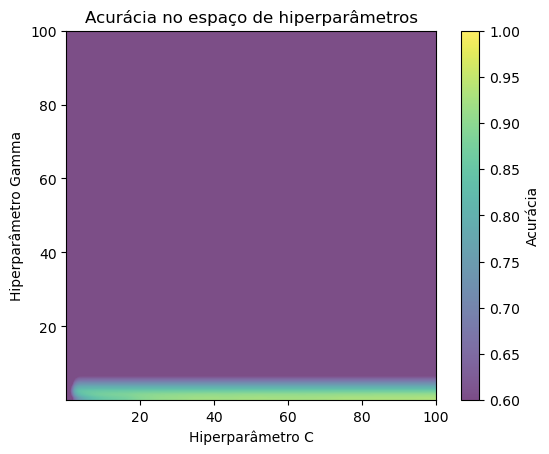

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# densidade_acuracia -> matriz de densidades 2D
# Aplicar suavização gaussiana para criar um efeito mais suave
sigma = 1  # Ajuste a suavidade
smoothed_density = gaussian_filter(densidade_acuracia.values, sigma=sigma)

# Usar 'imshow' com interpolação entre o espaço de hiperparâmetros que não percorremos
plt.imshow(
    smoothed_density,
    origin='lower',
    cmap='viridis',
    alpha=0.7,  # Transparência
    interpolation='gaussian',  # Interpolação suave
    extent=[0.01, 100, 0.01, 100],  # Limites do espaço vetorial dos hiperparametros,
    vmin = 0.6,
    vmax = 1
)

# Configurar rótulos dos eixos e título
plt.xlabel('Hiperparâmetro C')
plt.ylabel('Hiperparâmetro Gamma')
plt.title('Acurácia no espaço de hiperparâmetros')

# Adicionar uma barra de cor para referência visual
plt.colorbar(label='Acurácia')

# Exibir o mapa de calor
plt.show()

- Parametros com gamma < 1 otimizam mais a acurácia no modelo de SVM para esse problema

# 8 Simulação posições do enxame
- posição inicial -> posição MA 46ª iteração (onde 1 particula foi capaz de obter a melhor acurácia)

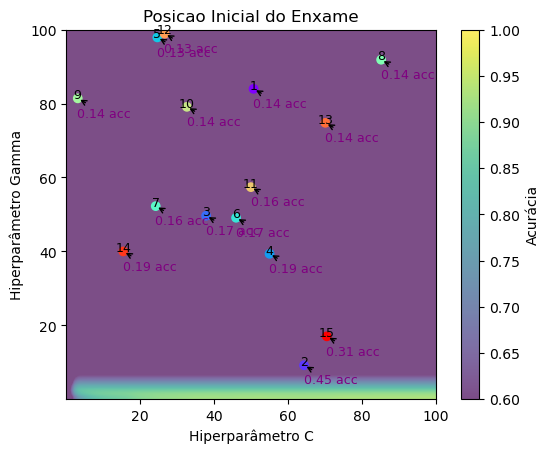

In [83]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np


# Define o número de pontos
num_pontos = n_particles

# Cria as posições iniciais e finais para os pontos
x_inicial = df_pos_inicial['C'].values
y_inicial = df_pos_inicial['gamma'].values

x_final = df_pos_final['C'].values
y_final = df_pos_final['gamma'].values

# Define cores para cada ponto
colors = plt.cm.rainbow(np.linspace(0, 1, num_pontos))

# Gera valores aleatórios para as flechas
flechas_iniciais = df_pos_inicial.accuracy.values
flechas_finais = df_pos_final.accuracy.values

# Cria a figura e o eixo
fig, ax = plt.subplots()



######################## Part 1: Plota o espaço vetorial de hiperparametros e a acurácia

# densidade_acuracia -> matriz de densidades 2D
# Aplicar suavização gaussiana para criar um efeito mais suave
sigma = 1  # Ajuste a suavidade
smoothed_density = gaussian_filter(densidade_acuracia.values, sigma=sigma)

# Usar 'imshow' com interpolação entre o espaço de hiperparâmetros que não percorremos
plt.imshow(
    smoothed_density,
    origin='lower',
    cmap='viridis',
    alpha=0.7,  # Transparência
    interpolation='gaussian',  # Interpolação suave
    extent=[0.01, 100, 0.01, 100],  # Limites do espaço vetorial dos hiperparametros,
    vmin = 0.6,
    vmax = 1
)

# Configurar rótulos dos eixos e título
plt.xlabel('Hiperparâmetro C')
plt.ylabel('Hiperparâmetro Gamma')
#plt.title('Simulação no espaço de hiperparâmetros')

# Adicionar uma barra de cor para referência visual
plt.colorbar(label='Acurácia')

######################## Fim Part 1




# Define os limites do gráfico para garantir que todos os pontos sejam visíveis
ax.set_xlim(0.01, 100)
ax.set_ylim(0.01, 100)

# Cria o scatter plot para a animação
scatter = ax.scatter(x_inicial, y_inicial, c=colors)

# Rótulos para cada ponto
labels = [ax.text(x, y, str(i + 1), fontsize=9, ha='center') for i, (x, y) in enumerate(zip(x_inicial, y_inicial))]

# Adiciona flechas para os pontos iniciais
flechas_iniciais_annot = [
    ax.annotate(
        f"{flechas_iniciais[i]:.2f} acc",
        xy=(x_inicial[i], y_inicial[i]),
        xytext=(x_inicial[i] - 0.1, y_inicial[i] - 5),  # Aproximação do texto para encurtar a flecha
        textcoords="data",
        arrowprops=dict(arrowstyle="->", color="black"),
        fontsize=9,
        color="purple",
    )
    for i in range(num_pontos)
]


# Número de quadros para a animação
num_frames = 100

# Função para atualizar a posição dos pontos e das anotações em cada quadro
def update(frame):

    
    # Interpolação linear entre posições iniciais e finais
    x_interpolated = x_inicial + frame * (x_final - x_inicial) / num_frames
    y_interpolated = y_inicial + frame * (y_final - y_inicial) / num_frames
    
    scatter.set_offsets(np.column_stack((x_interpolated, y_interpolated)))
    
    # Atualiza a posição dos rótulos
    for label, x, y in zip(labels, x_interpolated, y_interpolated):
        label.set_position((x, y))
    
    # Controla as flechas para mostrar apenas no início e no final
    if frame == 0:
        ax.set_title('Posicao Inicial do Enxame')
        for flecha in flechas_iniciais_annot:
            flecha.set_visible(True)
    elif frame == num_frames - 1:
        ax.set_title('Posicao Final - N_ITERACAO = 31')

        # No final, atualiza as flechas com valores de acuracia
        flechas_finais_annot = [
            ax.annotate(
                f"{flechas_finais[i]:.2f} acc",
                xy=(x_interpolated[i], y_interpolated[i]),
                xytext=(x_interpolated[i] - 0.1, y_interpolated[i] - 5),  # Menos cumprido
                textcoords="data",
                arrowprops=dict(arrowstyle="->", color="black"),
                fontsize=9,
                color="purple",
            )
            for i in range(num_pontos)
        ]
        return scatter, *labels, *flechas_finais_annot
    else:
        ax.set_title('')

        # No meio da animação, tornamos as flechas invisíveis
        for flecha in flechas_iniciais_annot:
            flecha.set_visible(False)
    
    return scatter, *labels

# Cria a animação
anim = animation.FuncAnimation(
    fig, update, frames=num_frames, blit=True, interval=50, repeat=False
)

# Exibe a animação
plt.show()

In [84]:
anim.save("./images/animação.gif", writer="imagemagick")

2024-04-28 22:40:20,576 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2024-04-28 22:40:20,577 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


# 9 Avaliação dados de teste
- Avaliaremos se o mínimo encontrado por PSO não overfitou!

In [77]:
X_test.head()

,Train_or_Test,Speaker_Number,Sex,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9
874,0.0,12.0,0.0,-3.075,1.824,-0.905,0.727,0.155,0.608,-0.075,-0.377,-0.740,0.852
595,0.0,7.0,1.0,-3.262,0.956,-0.791,1.528,-0.021,0.977,-0.121,0.499,-0.990,-0.621
564,0.0,6.0,1.0,-1.793,0.925,-0.739,-0.396,-0.211,0.329,-0.403,0.604,0.197,-0.251
726,0.0,13.0,1.0,-2.463,-0.197,-1.264,1.150,0.234,1.833,0.066,0.738,-1.382,-0.498
52,1.0,0.0,1.0,-3.543,1.391,-1.220,0.699,-0.769,1.579,-0.379,1.158,0.181,-0.178


In [78]:
model = SVC(random_state=seed)
model.set_params(**{'C': melhor_C, 'gamma': melhor_gamma})

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])


In [79]:
from sklearn.metrics import accuracy_score
pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)
accuracy_score(y_test, y_pred)

0.9755102040816327

- Performance em dados de treino de 97.5% semelhante aos observados nos dados de teste 94%!

# 10 Conclusões Gerais

- A exploração do enxame foi capaz de encontrar os melhores hiperparâmetros para um modelo de SVM
- Obtivemos 94% de acurácia em dados de treino e 97.5% em dados de teste. Sem overfit!
- Ja na 9ª iteração o PSO foi capaz de encontrar hiperparametros com 91.6% de acurácia!
- PSO convergiu para melhor solução na sua 46ª iteração com 94% de acurácia.
- Foram realizadas 80 iterações, após as 46ª iteração o enxame continuou explorando o espaço de hiperparâmetros limitando-se pelo espaço definido R2 e pelos fatores de velocidade definidos.

# 11 Conclusões específicas
- Os parâmetros de velocidade foram escolhidos para que o enxame pudesse explorar o máximo o espaço disponível. Por isso, nem todas as particulas finalizaram as iterações na região do ótimo global destacado em amarelo. Com N_iteracoes tendendo ao infinito ou suavizando os fatores de velocidade teriamos todas as partículas do enxame convergindo quase totalmente para área de melhor acurácia.